In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Uses inspect to create inspector and get columns from measurment table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Gets columns from station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Finds the most recent date in the data set
most_recent_date = session.query(Measurement.date).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(f"Most recent date is: {most_recent_date[0]}")

Most recent date is: 2017-08-23


In [12]:
# Starting from the most recent data point in the database,
# performs a query to retrieve the last 12 months of precipitation data and plot the results. 
last_12_mos = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23").all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12_mos, columns=["date", "precipitation"])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

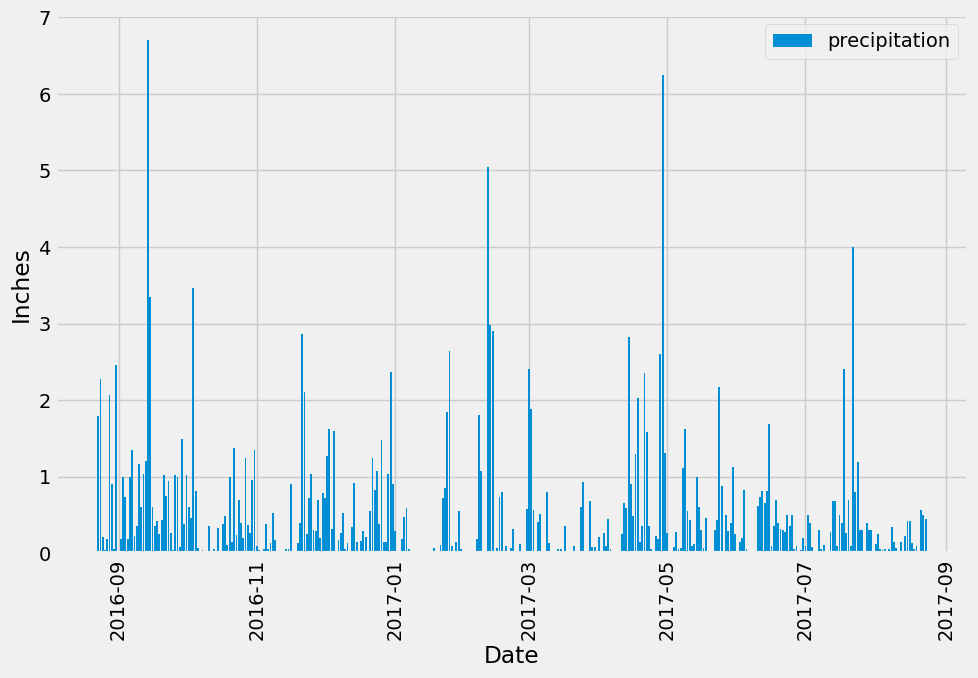

In [14]:
# Plots the data with Matplotlib
x = np.asarray(df.index, dtype='datetime64[D]')
plt.figure(figsize=(10, 7))
plt.bar(x, df['precipitation'])
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)  
plt.legend(['precipitation'])
plt.tight_layout()
plt.show()

In [15]:
# Calcualtes the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [16]:
# Query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [17]:
# Qquery to find the most active stations (i.e. what stations have the most rows) in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
print(f"Most 'active' stations (most rows of data)):\n{most_active_stations}")

Most 'active' stations (most rows of data)):
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Gets first station ID and assigns it to variable
i=0
for item in most_active_stations:
    while i < 1:
        first_station = (item[0])
        i += 1

# Using the most active station id from the previous query, calculates the lowest, highest, and average temperature.
most_active_station_stats = session.query(func.min(Measurement.tobs), \
                                    func.max(Measurement.tobs), \
                                    func.avg(Measurement.tobs).\
                                    filter(Measurement.station == "USC00519281")).all()
print(f"The lowest, highest, and average temperatures for station {first_station}:\n{most_active_station_stats[0]}")

The lowest, highest, and average temperatures for station USC00519281:
(53.0, 87.0, 71.66378066378067)


In [19]:
# Using the most active station id, queries the last 12 months of temperature observation data for this station 
last_12_mos_most_active_station = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23").all()

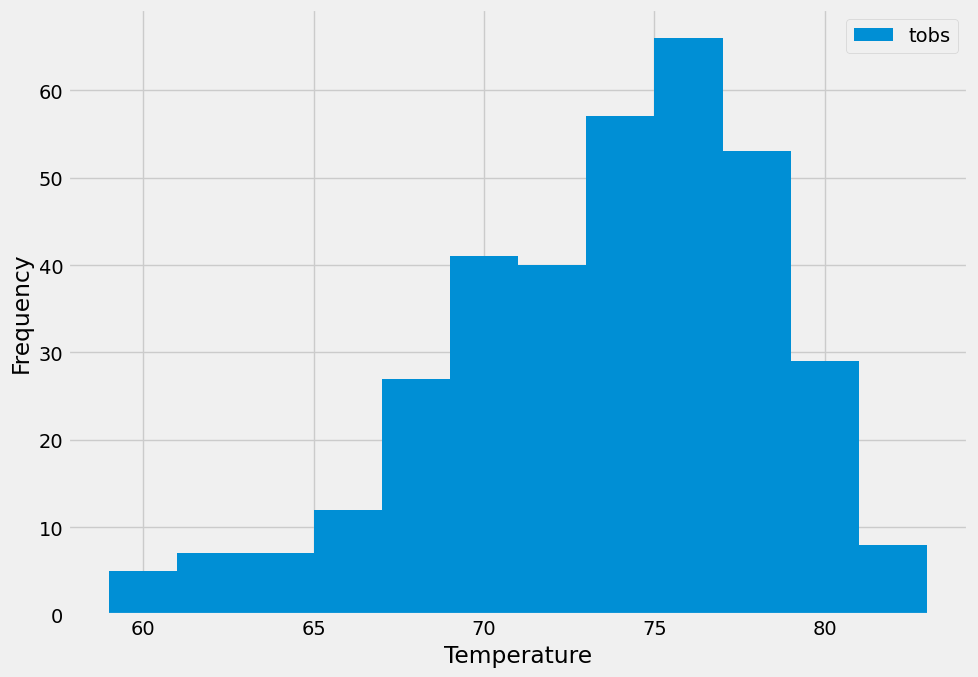

In [20]:
# Plots the results of 'last_12_mos_most_active_station' from above as a histogram
x = np.array(last_12_mos_most_active_station)
plt.figure(figsize=(10, 7))
plt.hist(x, bins=12)
plt.legend(['tobs'])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show() 

# Close session

In [21]:
# Close Session
session.close()